Hi all,
Next Monday (Feb 28th) we will hold the 4th coaching session about "Individual practice incorporating graphics into papers". As usual, you will be assigned to one breakout room with 5-6 fellow 1st-year Ph.D. students and 1 senior Ph.D. student as the coach. Please each bring 1-3 figures/plots/graphs about the potential final key result of your 599 project. It doesn't have to be a real result since most of us are not quite there yet. You can use fake data to create your own plot, or directly use available plots from the literature review.

The goal here is to use the plot to show the final output of your 599 project, which can be the ending part of your final presentation to the committee members.

In [2]:
# imports
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
warnings.simplefilter("ignore", UserWarning)
import nelpy as nel  
import nelpy.plotting as npl
import jagular as jag

In [3]:
prefix = '/home/kaylavokt/Desktop/Whrath/Day0/' # EDIT
rec = 'preFamSleep'
files = prefix + rec + '.rec' # EDIT
os.system("mkdir " + prefix + rec + "_channels")

# Tetrodes of use: 1, 3, 5, 7

#########################################################################
# jagular extraction parameters
jfm = jag.io.JagularFileMap(files) # jagular file map
max_gap_size = 10000 # maximum number of samples to interpolate
ts_out = prefix + rec + '_timestamps.raw' # output file, customize as needed
ch_out_prefix = prefix + rec + '_channels/'
subset = [0, 1, 2, 3, 8, 9, 10, 11, 16, 17, 18, 19, 24, 25, 26, 27] # which channels to extract
block_size = 2**21 # controls how much data to read at a time
verbose = False
###########################################################################

# jag.utils.extract_channels(
#     jfm=jfm,
#     max_gap_size=max_gap_size,
#     ts_out=ts_out,
#     ch_out_prefix=ch_out_prefix,
#     subset=subset,
#     block_size=block_size,
#     verbose=verbose
# )

In [4]:
ts = np.fromfile(prefix + rec + '_timestamps.raw', dtype = np.uint32) # raw timestamps not in seconds
timestamps = (ts -ts[0])/30000

In [5]:
# Create Analog Signal Array (ASA)
                               
ch1 = np.fromfile(prefix + rec + "_channels/ch.00.raw", dtype = np.int16)*0.195
asa1 = nel.AnalogSignalArray(ch1,timestamps=timestamps,fs=30000)

ch26 = np.fromfile(prefix + rec + "_channels/ch.26.raw", dtype = np.int16)*0.195
asa26 = nel.AnalogSignalArray(ch1,timestamps=timestamps,fs=30000)

In [8]:
# Detect Canonical Ripples
# Code from Josh's MS Defense

def extract_ripples(asa):
    eeg = nel.filtering.sosfiltfilt(asa, fl=150, fh=250)
    env = nel.utils.signal_envelope_1d(eeg, sigma=0.004)
    bounds, _, _ = nel.utils.get_events_boundaries(env.data,
    PrimaryThreshold=env.mean() + 3*env.std(),
    SecondaryThreshold=env.mean(),
    minThresholdLength=0.015,
    minLength=0.05,
    ds=1/env.fs)
    timebounds = env.time[bounds]
    timebounds[:, 1] += 1/env.fs
    return nel.EpochArray(timebounds)

ripple_epochs1 = extract_ripples(asa1)

ripple_epochs26 = extract_ripples(asa26)


In [9]:
# Min and Max Ripple Windows

mn = np.argmin(ripple_epochs1.lengths),ripple_epochs1.lengths[np.argmin(ripple_epochs1.lengths)]
print("Min = ", mn)

mx = np.argmax(ripple_epochs1.lengths),ripple_epochs1.lengths[np.argmax(ripple_epochs1.lengths)]
print("Max = ", mx)

Min =  (41, 0.05136666666663814)
Max =  (73, 0.29103333333330283)


/home/kaylavokt/anaconda3/envs/analysis/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).


Text(0, 0.5, 'Density')

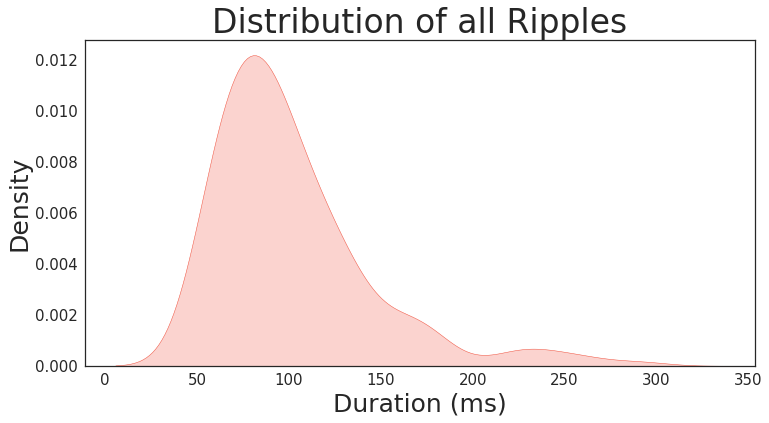

In [10]:
# Distribution of All Ripples
import seaborn as sns

npl.setup()
npl.set_palette(npl.colors.cows)
npl.setup(font='Universalis ADF Std', font_scale=2, style='white',\
         rc=({'figure.figsize': (12, 6), 'font.size': 18, 'axes.labelsize': 25, \
             'axes.titlesize':33, 'legend.fontsize': 20, 'ytick.labelsize': 15, 'xtick.labelsize': 15}))

ax = sns.distplot(ripple_epochs1.lengths*1000,color=npl.colors.sweet.red,kde=True,hist=False,kde_kws = {'shade': True, 'linewidth': 0.5},label='All ripples')
ax.set_title("Distribution of all Ripples")
ax.set_xlabel("Duration (ms)")
ax.set_ylabel("Density")

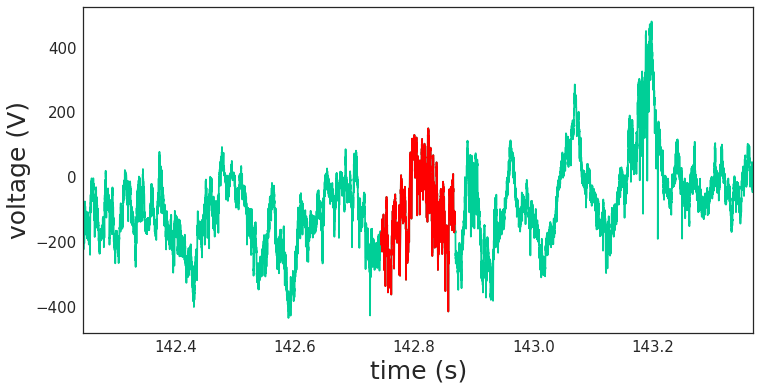

In [12]:
rippleNum = 23
npl.plot(asa1[ripple_epochs1[rippleNum].expand(0.5)])
npl.plot(asa1[ripple_epochs1[rippleNum]],color='red')

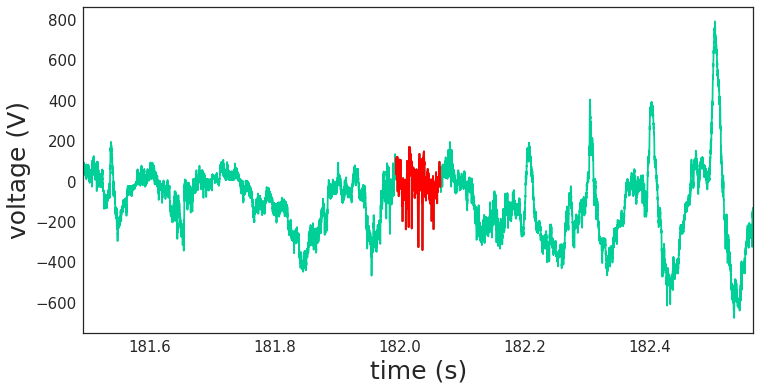

In [13]:
rippleNum = 24
npl.plot(asa1[ripple_epochs1[rippleNum].expand(0.5)])
npl.plot(asa1[ripple_epochs1[rippleNum]],color='red')

In [15]:
avg = ripple_epochs1.length / len(ripple_epochs1)
ripple_len = np.zeros(len(ripple_epochs1))
stdev = 0.025 # ms

for r in range(len(ripple_epochs1)):
    if ripple_epochs1[r].length < avg - stdev:
        ripple_len[r] = -1
    elif ripple_epochs1[r].length > avg + stdev:
        ripple_len[r] = 1

ripple_len


array([ 0.,  0., -1., -1.,  1.,  0.,  1.,  0.,  0., -1.,  0.,  0.,  1.,
        0.,  0.,  0.,  0.,  0.,  1.,  0.,  0., -1., -1.,  0., -1., -1.,
       -1.,  0., -1.,  0.,  0.,  1., -1.,  0.,  0.,  1.,  0.,  0.,  1.,
       -1., -1., -1.,  1.,  1., -1.,  0.,  1., -1.,  0.,  0.,  0., -1.,
        0.,  1.,  0.,  0.,  1., -1.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,
        1., -1.,  0., -1., -1.,  0., -1.,  0.,  1.,  0.,  1.,  0.,  1.,
        0.,  0., -1.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0., -1., -1.,
       -1., -1.,  0., -1., -1.,  0.,  0.,  1.,  1.,  0.,  0., -1.,  0.,
        0.,  0.,  0., -1.,  0.,  0.,  1.,  0.,  0.,  1.,  0., -1.,  0.,
        0., -1.,  0.,  0., -1.,  0.,  1.,  0., -1., -1.,  1.,  0.,  0.,
        0.,  0.,  1.,  0.,  0.,  1.,  0.,  0., -1., -1., -1.,  0.,  0.,
       -1.,  0.,  1.,  1., -1.,  1.,  0.,  1., -1., -1.,  1.,  0.,  1.,
        0., -1., -1., -1.,  0.,  0., -1.,  0.,  1., -1., -1.,  0.,  0.,
        0., -1., -1.,  0.,  0.,  0.,  0.,  1.,  0., -1., -1.,  0

/home/kaylavokt/anaconda3/envs/analysis/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
/home/kaylavokt/anaconda3/envs/analysis/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
/home/kaylavokt/anaconda3/envs/analysis/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-

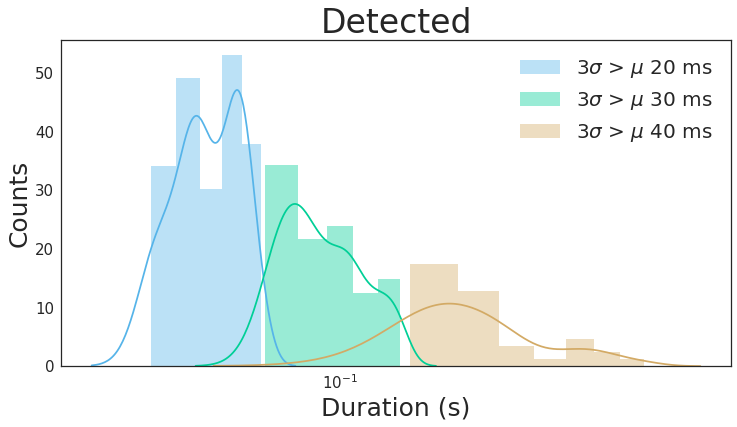

In [17]:
ax = plt.gca()
sns.distplot((ripple_epochs1.lengths[np.where(ripple_len==-1)[0]]),color=npl.colors.sweet.blue,label='3$\sigma$ > $\mu$ 20 ms',kde='True')
sns.distplot((ripple_epochs1.lengths[np.where(ripple_len==0)[0]]),color=npl.colors.sweet.green,label='3$\sigma$ > $\mu$ 30 ms',kde='True')
sns.distplot((ripple_epochs1.lengths[np.where(ripple_len==1)[0]]),color=npl.colors.sweet.gold,label='3$\sigma$ > $\mu$ 40 ms',kde='True')

plt.title("Detected")
plt.xscale("log")
plt.legend()
ax.set_xlabel("Duration (s)")
ax.set_ylabel("Counts")
plt.show()

/home/kaylavokt/anaconda3/envs/analysis/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
/home/kaylavokt/anaconda3/envs/analysis/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).


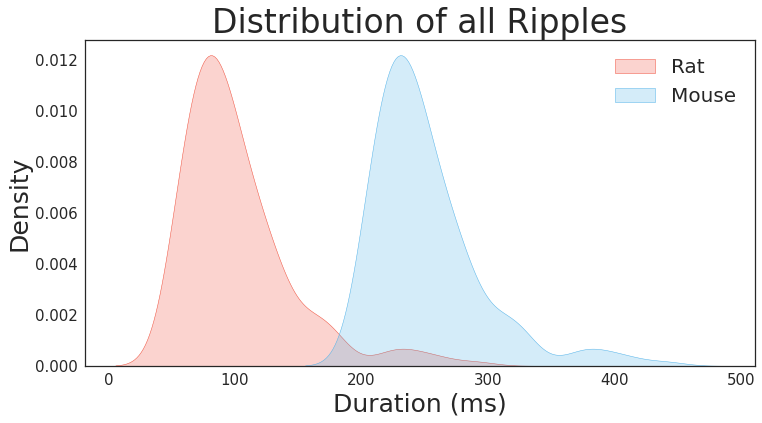

In [19]:
# Distribution of All Ripples
import seaborn as sns

ax = plt.gca()
npl.setup()
npl.set_palette(npl.colors.cows)
npl.setup(font='Universalis ADF Std', font_scale=2, style='white',\
         rc=({'figure.figsize': (12, 6), 'font.size': 18, 'axes.labelsize': 25, \
             'axes.titlesize':33, 'legend.fontsize': 20, 'ytick.labelsize': 15, 'xtick.labelsize': 15}))

sns.distplot(ripple_epochs1.lengths*1000,color=npl.colors.sweet.red,kde=True,hist=False,kde_kws = {'shade': True, 'linewidth': 0.5},label='Rat')
sns.distplot(ripple_epochs26.lengths*1000+150,color=npl.colors.sweet.blue,kde=True,hist=False,kde_kws = {'shade': True, 'linewidth': 0.5},label='Mouse')
ax.set_title("Distribution of all Ripples")
ax.set_xlabel("Duration (ms)")
ax.set_ylabel("Density")
plt.legend()



In [22]:
sample = asa1
sample._ordinate.base_unit='uV'
sample.add_signal(nel.filtering.sosfiltfilt(asa1[:,0],fl=6,fh=12,gpass=0.01,gstop=60,fs=30000),label='Theta')
sample.add_signal(nel.filtering.sosfiltfilt(asa1[:,0],fl=30,fh=50,gpass=0.01,gstop=60,fs=30000),label='SlowGamma')
sample.add_signal(nel.filtering.sosfiltfilt(asa1[:,0],fl=61,fh=100,gpass=0.01,gstop=60,fs=30000),label='FastGamma')
sample.add_signal(nel.filtering.sosfiltfilt(asa1[:,0],fl=150,fh=250,gpass=0.01,gstop=60,fs=30000),label='Ripple')


<AnalogSignalArray at 0x7f9352e7b668: 5 signals> for a total of 20:15:296 minutes

(-3000.0, 1000.0)

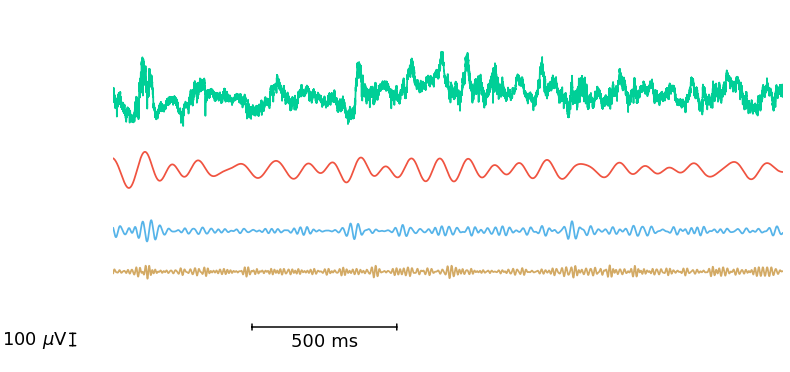

In [23]:
npl.setup()
npl.set_palette(npl.colors.cows)
npl.setup(font='Universalis ADF Std', font_scale=2, style='white',\
         rc=({'figure.figsize': (12, 6), 'font.size': 18, 'axes.labelsize': 25, \
             'axes.titlesize':33, 'legend.fontsize': 20, 'ytick.labelsize': 10, 'xtick.labelsize': 10}))

ax = plt.gca()
npl.plot(sample[:,0])
npl.plot(sample[:,1]-1000)
npl.plot(sample[:,2]-1750)
npl.plot(sample[:,3]-2250)

npl.utils.clear_left_right(ax)
npl.utils.clear_top_bottom(ax)

npl.scalebar.add_scalebar(ax=ax, sizey=200, labely='100 $\mu$V',  pad=0, loc=3,bbox_to_anchor=(0,20))
npl.scalebar.add_scalebar(ax=ax, sizex=0.5,labelx='500 ms', pad=0, loc=3,bbox_to_anchor=(250,20))

a = 15
b = 2.25
ax.set_xlim(a,a+b)
ax.set_ylim(-3000,1000)

In [24]:
# Theta, Slow Gamme, Fast Gamma, Ripple